In [1]:
import pandas as pd
from itertools import combinations
import random
import matplotlib.pyplot as plt
from textwrap import wrap
from datetime import datetime
import pytesseract
from PIL import Image
import io
from IPython.display import display
import ipywidgets as widgets

# Load the DataFrame from CSV
df = pd.read_csv('/Users/alishawadkar/Documents/Webapp/starsdb.csv')

def filter_courses(df, degree, courses_taken):
    # Filter the DataFrame based on degree and courses taken
    filtered_df = df[(df['Programme'] == degree) & 
                     (~df['Course Code'].isin(courses_taken))]
    return filtered_df

# User inputs
degree = input("Enter your degree: ")

# Define a function to handle the image upload
def handle_image_upload(change):
    global courses_taken
    # Get the uploaded image
    uploaded_image = change['new'][0]
    
    # Read the image from the uploaded file
    img = Image.open(io.BytesIO(uploaded_image['content']))
    
    # Use Tesseract to do OCR on the image
    text = pytesseract.image_to_string(img)
    
    # Print the extracted text
    print("Extracted text:")
    print(text)
    
    # Split the text into lines
    lines = text.strip().split('\n')

    # Extract the column you want (e.g., the second column)
    column_index = 2  # Adjust index based on zero-based indexing
    courses_taken = [line.split()[column_index] for line in lines[2:]]  # Skip header line

    # Print the extracted column data
    print("Extracted courses taken:")
    print(courses_taken)

# Create a FileUpload widget
file_upload = widgets.FileUpload()

# Register the function to handle the image upload event
file_upload.observe(handle_image_upload, names='value')

# Display the FileUpload widget
display(file_upload)


Enter your degree: EEE


FileUpload(value=(), description='Upload')

Extracted text:
Academic Semester Course Course Index Course Course s/U Grade
Year AU No Type Group option
2023 2 CC0007 SCIENCE & TECHNOLOGY FOR HUMANITY 3 83044 ie ICC
2023 2 EE2005 ELECTRICAL DEVICES & MACHINES 3 32096 ie
2023 2 EE2073 INTRODUCTION TO EEE DESIGN & PROJECT 2 32117 ie
2023 2 EE2102 ANALOG ELECTRONICS 3 32129 ie
2023 2 1E2104 DIGITAL ELECTRONICS 3 32184 ie
2023 2 1E2107 ENGINEERING MATHEMATICS II 3 32148 ie
2023 2 1E2110 SIGNALS & SYSTEMS 3 32431 ie
2023 1 CC0006 SUSTAINABILITY: SOCIETY, ECONOMY & ENVIRONMENT 3 85923 Cc ICC
2023 1 EE2101 CIRCUIT ANALYSIS 3 32083 Cc
2023 1 EE2103 SEMICONDUCTOR FUNDAMENTALS 3 32104 Cc
2023 1 IE2104 DIGITAL ELECTRONICS 3 32119 Cc
2023 1 IE2106 ENGINEERING MATHEMATICS | 3 32139 Cc
2023 1 LC5001 CHINESE LANGUAGE LEVEL 1 3 18012 BDE
2023 1 ML0004 CAREER & INNOVATIVE ENTERPRISE FOR THE FUTURE WORLD 2 84780 Cc ICC
2022 2 C0003 ETHICS & CIVICS INA MULTICULTURAL WORLD 2 83883 ie ICC
2022 2 C0005 HEALTHY LIVING & WELLBEING 3 84600 ie ICC
2022 2 E

#### 

Total AU: 16
[]


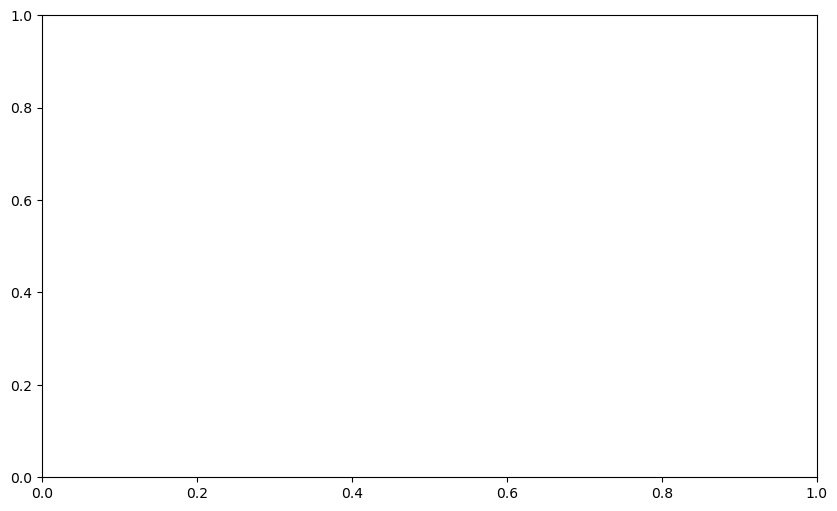

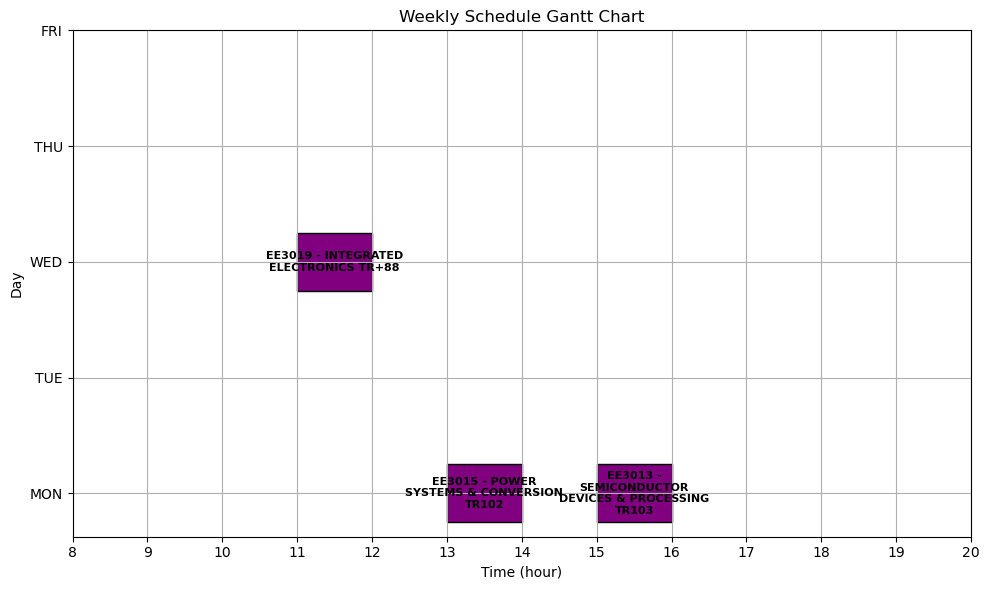

Randomly chosen combination of courses:
1. Course Code: EE3013, Course Name: SEMICONDUCTOR DEVICES & PROCESSING, Index: 33081
2. Course Code: EE3018, Course Name: INTRODUCTION TO PHOTONICS, Index: 33093
3. Course Code: EE3019, Course Name: INTEGRATED ELECTRONICS, Index: 33097


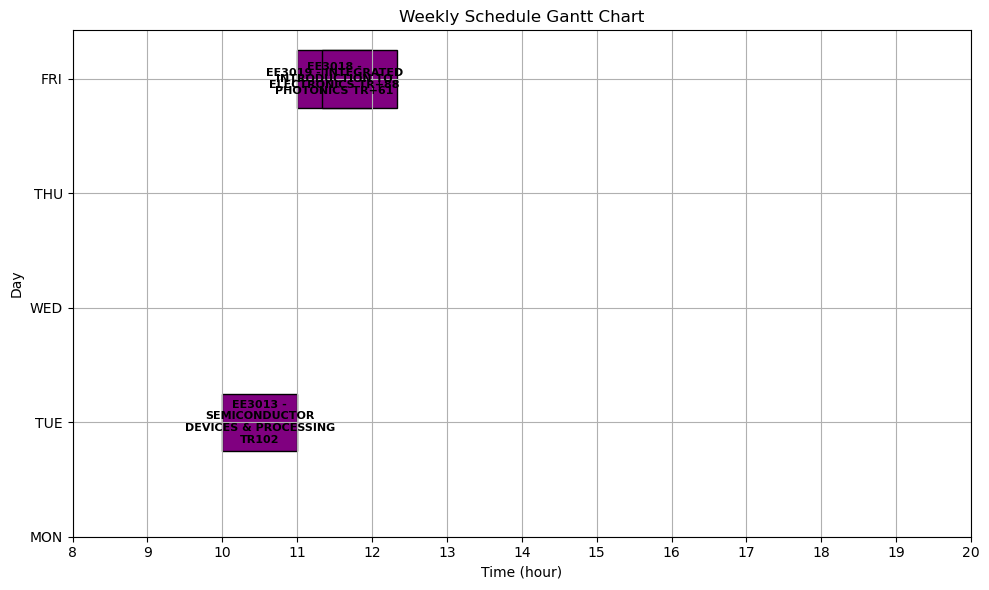

Index of chosen courses:


TypeError: 'Course' object is not subscriptable

In [2]:
# Filter the DataFrame
filtered_df = filter_courses(df, degree, courses_taken)

# Use the filtered DataFrame for further processing
starsdb = filtered_df

def find_combinations(db, target_au):
    # Drop duplicates to avoid counting courses multiple times
    starsdb_no_duplicates = db.drop_duplicates(subset=['Course Code'])
    courses = starsdb_no_duplicates['Course Code'].tolist()
    au_values = starsdb_no_duplicates['AU'].tolist()
    combined_list = list(zip(courses, au_values))
    
    possible_combinations = []
    unique_combinations = []

    # Find combinations of courses that add up to the target AU
    for r in range(1, len(combined_list) + 1):
        for combo in combinations(combined_list, r):
            if not check_collision(combo):
                total_au = sum(au for _, au in combo)
                if total_au == target_au:
                    courses_only = [course for course, _ in combo]
                    possible_combinations.append(courses_only)

    # Remove duplicates from possible combinations
    for sublist in possible_combinations:
        unique_sublist = list(set(sublist))
        unique_sublist.sort()
        if unique_sublist not in unique_combinations:
            unique_combinations.append(unique_sublist)

    return unique_combinations

def check_collision(combination):
    """
    Check if there is any collision (day, start time, end time) within the given combination of courses.
    """
    schedule = {}
    for course, _ in combination:
        course_info = starsdb[starsdb['Course Code'] == course].iloc[0]
        day = course_info['Day']
        start_time = course_info['Start Time']
        end_time = course_info['End Time']
        for i in range(start_time, end_time):
            if (day, i) in schedule:
                return True  # Collision found
            schedule[(day, i)] = True
    return False  # No collision found

total_au = int(input("Total AU: "))
print(find_combinations(starsdb, total_au))

# Remove courses from filtered_df that are not present in starsdb
filtered_df = filtered_df[filtered_df['Course Code'].isin(starsdb['Course Code'])]

# Define the Course class
class Course:
    def __init__(self, code, name, start_time, end_time, day, venue):
        self.code = code
        self.name = name
        self.start_time = start_time
        self.end_time = end_time
        self.day = day[:3].upper()  # Convert to uppercase for consistency
        self.venue = venue


# Function to generate a schedule based on a list of course modules
def generate_schedule(course_modules):
    schedule = []
    for idx, course in enumerate(course_modules):
        # Convert integer start time and end time to string before parsing
        start_time = datetime.strptime(str(course['Start Time']), '%H%M').time()
        end_time = datetime.strptime(str(course['End Time']), '%H%M').time()
        schedule.append(Course(course['Course Code'], course['Title'], start_time, end_time, course['Day'], course['Venue']))
    return schedule


# Convert DataFrame to Course objects
filtered_courses = filtered_df.to_dict('records')

# Select a random combination of courses from filtered courses
random_combination = random.choice(list(combinations(filtered_courses, 3)))

# Generate schedule based on the random combination
schedule = generate_schedule(random_combination)

# Prepare data for Gantt chart
days = ['MON', 'TUE', 'WED', 'THU', 'FRI']
timings = list(range(8, 20))
course_data = {day: [[] for _ in range(len(timings))] for day in days}

# Fill in course data
for course in schedule:
    day_index = days.index(course.day)
    for hour_index in range(course.start_time.hour - 8, course.end_time.hour - 8):
        if hour_index >= 0 and hour_index < len(timings):
            course_data[course.day][hour_index].append(course)

# Plot Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))
# Plot Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_height = 0.5

for i, day in enumerate(days):
    for j, hour in enumerate(timings):
        courses = course_data[day][j]
        num_courses = len(courses)
        if num_courses > 0:
            bar_width = 1 / (num_courses + 1)
            for k, course in enumerate(courses):
                left_pos = course.start_time.hour + k * bar_width
                ax.barh(i, course.end_time.hour - course.start_time.hour, 
                         left=left_pos, height=bar_height, color='purple', edgecolor='black', align='center')
                wrapped_text = "\n".join(wrap(f"{course.code} - {course.name}\n{course.venue}", width=20))
                ax.text((course.start_time.hour + course.end_time.hour) / 2, i, wrapped_text, ha='center', va='center', fontsize=8, fontweight='bold', color='black')

ax.set_xlabel('Time (hour)')
ax.set_ylabel('Day')
ax.set_title('Weekly Schedule Gantt Chart')
ax.set_xlim(8, 20)
ax.set_xticks(range(8, 21))
ax.set_yticks(range(len(days)))
ax.set_yticklabels(days)
ax.grid(True)
ax.set_facecolor('white')  # Set background color
fig.patch.set_facecolor('white')  # Set figure background color
ax.spines['bottom'].set_color('black')  # Set color of bottom spine
ax.spines['top'].set_color('black')  # Set color of top spine
ax.spines['left'].set_color('black')  # Set color of left spine
ax.spines['right'].set_color('black')  # Set color of right spine
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Select a random combination of courses from filtered courses
random_combination = random.choice(list(combinations(filtered_courses, 3)))

# Print the randomly chosen combination of courses with their indices
print("Randomly chosen combination of courses:")
for idx, course in enumerate(random_combination):
    course_index = filtered_courses.index(course)
    print(f"{idx + 1}. Course Code: {course['Course Code']}, Course Name: {course['Title']}, Index: {course['Index']}")

# Generate schedule based on the random combination
schedule = generate_schedule(random_combination)

# Prepare data for Gantt chart
days = ['MON', 'TUE', 'WED', 'THU', 'FRI']
timings = list(range(8, 20))
course_data = {day: [[] for _ in range(len(timings))] for day in days}

# Fill in course data
for course in schedule:
    day_index = days.index(course.day)
    for hour_index in range(course.start_time.hour - 8, course.end_time.hour - 8):
        if hour_index >= 0 and hour_index < len(timings):
            course_data[course.day][hour_index].append(course)

# Plot Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_height = 0.5

for i, day in enumerate(days):
    for j, hour in enumerate(timings):
        courses = course_data[day][j]
        num_courses = len(courses)
        if num_courses > 0:
            bar_width = 1 / (num_courses + 1)
            for k, course in enumerate(courses):
                left_pos = course.start_time.hour + k * bar_width
                ax.barh(i, course.end_time.hour - course.start_time.hour, 
                         left=left_pos, height=bar_height, color='purple', edgecolor='black', align='center')
                wrapped_text = "\n".join(wrap(f"{course.code} - {course.name}\n{course.venue}", width=20))
                ax.text((course.start_time.hour + course.end_time.hour) / 2, i, wrapped_text, ha='center', va='center', fontsize=8, fontweight='bold', color='black')

ax.set_xlabel('Time (hour)')
ax.set_ylabel('Day')
ax.set_title('Weekly Schedule Gantt Chart')
ax.set_xlim(8, 20)
ax.set_xticks(range(8, 21))
ax.set_yticks(range(len(days)))
ax.set_yticklabels(days)
ax.grid(True)
ax.set_facecolor('white')  # Set background color
fig.patch.set_facecolor('white')  # Set figure background color
ax.spines['bottom'].set_color('black')  # Set color of bottom spine
ax.spines['top'].set_color('black')  # Set color of top spine
ax.spines['left'].set_color('black')  # Set color of left spine
ax.spines['right'].set_color('black')  # Set color of right spine
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Calculate and print the index of courses chosen into a list
chosen_courses_index = [filtered_courses.index(course) for course in random_combination]
print("Index of chosen courses:")
for idx, course_index in enumerate(chosen_courses_index):
    print(f"{idx + 1}. Course Index: {course['Index']}")
